In [1]:
from pathlib import Path
import re
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from scipy import stats

In [153]:
class fast_processing_engine():
    """This is a class to automatically process raw 10Hz files that have already been run through cardconvert"""
    
    def __init__(self, converted_dirs, metadata_fn, file_length, acq_freq, start_time, end_time, site_names, out_dir):
        """converted_dirs - list of str
            directories containing raw converted TOA5 files. Each directory contains all the data to process from a given site, with no sub-directories. 
            For example, the following is an acceptable storage format:
                Converted/file1.dat
                Converted/file2.dat
            But the following is not accepted:
                Converted/2021/file1.dat
                Converted/2022/file2.dat
        metadata_dir - str
            the filename of the metadata .xlsx file. This isn't really used, but you should know where it is because it's important for manually keeping track of changes. It's the "Alex Fieldnotes CHanges" file or something.
        file_length - int
            file length in minutes
        acq_freq - int
            acquisition speed in Hz
        start_time, end_time - str 
            the start and end dates for the files to process in <yyyy-mm-dd hh:MM> format. Round DOWN to the nearest half-hour.
        site_names - list of str
            site names to combine. If only one site is provided, then the data will be simply reformatted with consistent headers and regrouped into uniform intervals. If more than one is provided, then all provided data will be merged together as well (concatenated column-wise). Must be in the same order as converted_dirs. If
        out_dir - str
            desired output/processing directory."""
        
        # sheet names in the metadata excel file
        header_sheets = {
                "BB-NF17": "NF 17m 10Hz Code",
                "BB-NF3": "NF 3m 10Hz Code"
        }
        
        # the final headers to use, grouped by site name.
        final_headers = {
            "BB-NF17": ["TIMESTAMP", "RECORD", "Ux_CSAT3_NF17", "Uy_CSAT3_NF17", "Uz_CSAT3_NF17", "Ts_CSAT3_NF17", "Ux_CSAT3_NF7", "Uy_CSAT3_NF7", "Uz_CSAT3_NF7", "Ts_CSAT3_NF7", "rho_c_LI7500_NF17", "rho_v_LI7500_NF17", "P_LI7500_NF17", "DIAG_CSAT3_NF17", "DIAG_CSAT3_NF7", "DIAG_LI7500_NF17"],
            "BB-NF3": ["TIMESTAMP", "RECORD", "Ux_CSAT3B_NF3", "Uy_CSAT3B_NF3", "Uz_CSAT3B_NF3", "Ts_CSAT3B_NF3", "rho_c_LI7500_NF3", "rho_v_LI7500_NF3", "P_LI7500_NF3", "DIAG_CSAT3_NF3", "DIAG_LI7500_NF3"]
        }
        
        # all site-specific metadata is stored here
        self.site_info = {site:{"fns":None, 
                                "file_tss":None, 
                                "desired_file_tss":None, 
                                "converted_path":Path(converted_dir), 
                                "n_files_converted":None,
                                "rawfile_metadata":None,
                                "header_sheet":header_sheets[site],
                                "header_metadat":None,
                                "final_header":final_headers[site]
                               }
                         for site, converted_dir in zip(site_names, converted_dirs)}
        
        # convert user-provided start/end times
        self.start_time = pd.to_datetime(start_time)
        self.end_time = pd.to_datetime(end_time)

        # convert acq freq to an interval for better compatibility with time deltas
        self.acq_freq = acq_freq
        self.acq_period = pd.Timedelta(f'{1000//self.acq_freq} ms')
        
        self.file_length = file_length
        self.n_records = self.file_length*self.acq_freq*60

        # convert files and directories to path objects and create an output directory
        self.out_path = Path(out_dir)
        self.metadata_path = Path(metadata_fn)
        if not self.out_path.exists():
            self.out_path.mkdir(parents=True)
        return
    
    def get_timestamp_from_fn(self, fn):
        """given a raw, converted file, this will extract the timestamp given in its name. Files are expected to be of the format TOA5*Hz*_yyyy_mm_dd_hh_MM.dat"""
        file_id = Path(fn).name.split('Hz')[1]
        file_start_str = "".join(re.split("_|\.", file_id)[1:-1])
        file_start_ts = pd.to_datetime(file_start_str, format="%Y%m%d%H%M")
        return file_start_ts
    
    def get_fn_from_timestamp(self, file_start_ts, site):
        """given a timestamp, this will find the exact file name it's associated with"""
        file_start_str = (f'{file_start_ts.year:04d}_' + 
                          f'{file_start_ts.month:02d}_' + 
                          f'{file_start_ts.day:02d}_' + 
                          f'{file_start_ts.hour:02d}{file_start_ts.minute:02d}')

        # if the file exists
        for i, fn in enumerate(self.site_info[site]['fns']):
            if file_start_str in str(fn):
                return fn

        # if not
        return
    
    def find_fast_files(self):
        """find all the raw data files that the user wants to process and place them in the site info dict, ordered by timestamp."""
        
        for site in self.site_info:
            # get the timestamps we want create, which may not align with the raw file timestamps
            self.desired_file_tss = pd.date_range(self.start_time, self.end_time, freq=f'{self.file_length} min')
            
            # retrieve the raw file names
            self.site_info[site]['fns'] = list(self.site_info[site]['converted_path'].glob("TOA5*.dat"))
            
            # get raw file timestamps from the raw file names
            file_tss = []
            for fn in self.site_info[site]['fns']:
                fts = self.get_timestamp_from_fn(fn)
                if (fts >= self.start_time and fts <= self.end_time):
                    file_tss.append(self.get_timestamp_from_fn(fn))
            
            # sort file names by timestamp
            file_tss = sorted(file_tss)
            self.site_info[site]['fns'] = [self.get_fn_from_timestamp(fts, site) for fts in file_tss]
            self.site_info[site]['file_tss'] = file_tss.copy()
            
            # also record the number of total files we converted
            self.site_info[site]['n_files_converted'] = len(file_tss)
      
    def metadata_template(self):
        """create a blank template to store raw TOA5 file metadata in. This can be referenced later for debugging purposes"""
        
        for site in self.site_info:
            rawfile_metadata = pd.DataFrame(
                data=np.zeros((self.site_info[site]['n_files_converted'], 8), dtype=str),
                columns=['Encoding', 'Station_name', 'Datalogger_model', 'Datalogger_serial_number', 'Datalogger_OS_version', 'Datalogger_program_name', 'Datalogger_program_signature', 'Table_name']
            )
            rawfile_metadata['File_name'] = self.site_info[site]['fns']
            rawfile_metadata['TIMESTAMP'] = self.site_info[site]['file_tss']
            rawfile_metadata['out_fn'] = np.NAN
            rawfile_metadata.set_index('TIMESTAMP', inplace=True)

            self.site_info[site]['rawfile_metadata'] = rawfile_metadata.copy()
        
        return
    
    def summary_template(self):
        """initialize the summary dataframe. Used by standardize_fast_files"""
        full_header = []
        for site in self.site_info:
            full_header += self.site_info[site]['final_header'][2:]
            
        summary_header = []
        for colname in full_header:
            summary_header.append(colname + '_Max')
            summary_header.append(colname + '_Min')
            summary_header.append(colname + '_Std')
            summary_header.append(colname + '_Mean')
            summary_header.append(colname + '_NANPct')
        summary_data = np.empty((len(self.desired_file_tss), len(summary_header)))
        return summary_data, summary_header
        
    
    def get_fast_header_info(self):
        """Site headers change over time. This retrieves the manually entered header data. Used for manual debugging"""
        
        for site in self.site_info:
            print(site)
            metadat = pd.read_excel(self.metadata_path, sheet_name = self.site_info[site]['header_sheet'])
            metadat['Date_yyyymmdd'] = pd.to_datetime(metadat['Date_yyyymmdd'], format='%Y%m%d')
            self.site_info[site]['header_metadat'] = metadat.copy()
        return
    
    def reorder_headers(self, site, fts, df):
        """Data headers change over time as the site evolves. This method will rearrange the dataframe to fit into a standard-order header, given the site name and date. All such metadata is input manually. Refer to self.site_info[site]['header_metadat'] for help crafting these.
        
        steps:
            1. Identify the site
            2. Identify the date
            3. Given the date and the site, save the missing columns, as well as the order to rearrange the columns
            4. Add the missing columns
            5. Rearrange the columns
            6. Rename the columns to the standard header"""
        
        # identify the site
        if site == 'BB-NF17':
            # identify the date
            if fts.date() < pd.to_datetime("2019-05-19"):
                # identify which columns in the final standardized header are missing from the raw data header
                cols_to_add = ["P_LI7500_NF17", "DIAG_CSAT3_NF17", "DIAG_CSAT3_NF7"]
                # identify how we should re-order these columns to fit into the new dataset. The new_order[i] gives the index of the old header that will be moved to index i
                new_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 12]
            elif fts.date() > pd.to_datetime("2019-05-19"):
                cols_to_add = ["DIAG_CSAT3_NF17", "DIAG_CSAT3_NF7"]
                new_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 13]
            # if the file ever overlaps with a "maintenance" day, omit that whole day
            elif fts.date() == pd.to_datetime("2019-05-19"):
                cols_to_add = []
                df = pd.DataFrame(np.full((1, len(self.site_info[site]['final_header'])), np.nan), 
                                  columns=self.site_info[site]['final_header'])
                df['TIMESTAMP'] = fts + pd.Timedelta(f'{self.acq_period} mSec')
                df.set_index('TIMESTAMP', inplace=True)
                return df
                
        elif site == "BB-NF3":
            if fts.date() < pd.to_datetime("2019-05-19"):
                cols_to_add = ["P_LI7500_NF3"]
                new_order = [0, 1, 2, 3, 4, 5, 6, 7, 10, 8, 9]
            elif fts.date() > pd.to_datetime("2019-05-19"):
                cols_to_add = ["DIAG_CSAT3B_NF3"]
                new_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 9]
            
            # if the file ever overlaps with a "maintenance" day, omit the whole day
            elif fts.date() == pd.to_datetime("2019-05-19"):
                cols_to_add = []
                df = pd.DataFrame(np.full((1, len(self.site_info[site]['final_header'])), np.nan), 
                                          columns=self.site_info[site]['final_header'])
                df['TIMESTAMP'] = fts + pd.Timedelta(f'{self.acq_period} mSec')
                df.set_index('TIMESTAMP', inplace=True)
                return df
        
        # once the cols_to_add and the new_order have been identified, appply them to the data
        # first, add columns
        for col in cols_to_add:
                    df[col] = np.nan
        # then, re-order those columns
        df = df.iloc[:, new_order]
        # finally, rename those columns using the standardized header names.
        df.columns = self.site_info[site]['final_header']
        
        return df
    
    def standardize_fast_files(self):
        """reads in raw fast files, and combines/standardizes them to be continuous."""
        
        # sanity check
        print("Processing data from...")
        for site in self.site_info:
            print(f"Site {site} in {self.site_info[site]['converted_path']}")
        print("Outputting data to...")
        print(self.out_path)
        input("Press Enter to confirm")
        
        # locate the files we're interested in
        self.find_fast_files()
        
        # initialize the summary dataframe
        summary_data, summary_header = self.summary_template()
        
        # we'll be popping file names off of fns and file_tss, so we'll create temporary copies of them first to avoid destroying the originals
        for site in self.site_info:
            self.site_info[site]['fns_temp'], self.site_info[site]['file_tss_temp'] = self.site_info[site]['fns'].copy(), self.site_info[site]['file_tss'].copy()
        
        # start processing files by desired start timestamp:
        
        # loop through OUTPUT file timestamps/names
        for idfts, dfts in enumerate(tqdm(self.desired_file_tss)):
            
            # for a given output file, generate the desired time index for that file
            desired_time_index = pd.date_range(dfts + self.acq_period, periods=self.n_records, freq=self.acq_period)
            dat = pd.DataFrame(desired_time_index, columns=['TIMESTAMP'])
            dat.set_index('TIMESTAMP', inplace=True)
            
            # get the TOA5 metadata stored in the raw file
            dfts_str = re.sub('-| ', '_', str(dfts))
            dfts_str = re.sub(':', '', dfts_str)[:-2]
            desired_fn = self.out_path / f'{dfts_str}.csv'
            
            # now loop through each site at this desired timestamp. 
            for site in self.site_info:
                
                # find qualified files for this timestamp. Whenever a valid file is found, pop it off the temp list.
                next_file_ts = dfts + pd.Timedelta(f'{self.file_length} Min')
                next_fns, next_file_tss = [], []
                try:
                    while self.site_info[site]['file_tss_temp'][0] < next_file_ts:
                        next_fns.append(self.site_info[site]['fns_temp'].pop(0))
                        next_file_tss.append(self.site_info[site]['file_tss_temp'].pop(0))
                except IndexError as err:
                    pass
                
                # concatenate the qualified files along the time axis
                # if no valid files are found, just make a null dataframe
                if next_fns == []:
                    rawdat = pd.DataFrame(np.full((1, len(self.site_info[site]['final_header'])), np.nan), 
                                          columns=self.site_info[site]['final_header'])
                    rawdat['TIMESTAMP'] = desired_time_index[0]
                    rawdat.set_index('TIMESTAMP', inplace=True)
                    rawdat = rawdat.loc[:, rawdat.columns != 'RECORD']
                    
                # otherwise, proceed as normal
                else:
                    # loop through all valid files for this timestamp. Convert them to the proper format and apply any calibrations/corrections that are needed.
                    for i, fn, ts in zip(range(len(next_fns)), next_fns, next_file_tss):
                        if i == 0:
                            rawdat = pd.read_csv(fn, sep=',', header=[0], skiprows=[0, 2, 3], na_values = ['NAN', '-4400906'])
                            rawdat['TIMESTAMP'] = pd.to_datetime(rawdat['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
                            rawdat = self.reorder_headers(site, ts, rawdat)
                            rawdat.set_index('TIMESTAMP', inplace=True)
                            rawdat = rawdat.loc[:, rawdat.columns != 'RECORD']
                        else:
                            rawdat_tmp = pd.read_csv(fn, sep=',', header=[0], skiprows=[0, 2, 3], na_values = ['NAN', '-4400906'])
                            rawdat_tmp['TIMESTAMP'] = pd.to_datetime(rawdat_tmp['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
                            rawdat = self.reorder_headers(site, ts, rawdat)
                            rawdat_tmp.set_index('TIMESTAMP', inplace=True)
                            rawdat = rawdat.loc[:, rawdat.columns != 'RECORD']
                            rawdat = pd.concat([rawdat, rawdat_tmp])
                            with open(fn) as f: self.site_info[site]['rawfile_metadata'].loc[ts] = f.readline()[1:-2].split('","') + [fn, desired_fn]

                # now that we have a complete, standardized output file for this site, merge it onto the master dataframe (column-wise) to add to all the other sites
                dat = dat.merge(rawdat, how='outer', left_index=True, right_index=True, sort=True)
            
            # save the full-sized standardized output file to a .csv. This output files contains all the data combined across all given sites.
            dat.to_csv(desired_fn, sep=',', na_rep='NAN', index=False, index_label=False, line_terminator='\n')

            # write summary stats for analysis and QA/QC
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                for icolname, colname in enumerate(dat.columns):
                    
                    summary_row = np.array([
                        np.nanmax(dat[colname]),
                        np.nanmin(dat[colname]),
                        np.nanstd(dat[colname]),
                        np.nanmean(dat[colname]),
                        100 - 100*np.nansum(0*dat[colname] + 1)/self.n_records
                    ])
                    summary_data[idfts, icolname*5:icolname*5 + 5] = summary_row
        self.summary = pd.DataFrame(summary_data, columns=summary_header)
        self.summary['TIMESTAMP'] = self.desired_file_tss
        self.summary.set_index('TIMESTAMP', inplace=True)
        
        return
        

In [154]:
converted_dirs = ["/Volumes/TempData/Bretfeld Mario/Chimney-Park-Reprocessing-Sandbox/Alex Work/Bad/Chimney/EC Processing/BB-NF/Fast/17m/Converted",
                 "/Volumes/TempData/Bretfeld Mario/Chimney-Park-Reprocessing-Sandbox/Alex Work/Bad/Chimney/EC Processing/BB-NF/Fast/3m/Converted"]
metadata_fn = "/Volumes/TempData/Bretfeld Mario/Chimney/Site Information/Changelog_Alex_fieldnotes.xlsx"
file_length = 30
acq_freq = 10
start_time = "2021-03-06 00:00"
end_time = "2021-03-31 00:00"
site_names = ["BB-NF17", "BB-NF3"]
out_dir = "/Volumes/TempData/Bretfeld Mario/Chimney-Park-Reprocessing-Sandbox/Alex Work/Bad/Chimney/EC Processing/BB-NF/Fast/Combined/Standardized"

In [ ]:
processor = fast_processing_engine(converted_dirs, metadata_fn, file_length, acq_freq, start_time, end_time, site_names, out_dir)
processor.standardize_fast_files()

Processing data from...
Site BB-NF17 in /Volumes/TempData/Bretfeld Mario/Chimney-Park-Reprocessing-Sandbox/Alex Work/Bad/Chimney/EC Processing/BB-NF/Fast/17m/Converted
Site BB-NF3 in /Volumes/TempData/Bretfeld Mario/Chimney-Park-Reprocessing-Sandbox/Alex Work/Bad/Chimney/EC Processing/BB-NF/Fast/3m/Converted
Outputting data to...
/Volumes/TempData/Bretfeld Mario/Chimney-Park-Reprocessing-Sandbox/Alex Work/Bad/Chimney/EC Processing/BB-NF/Fast/Combined/Standardized


Press Enter to confirm 


 22%|██▏       | 270/1201 [02:18<10:27,  1.48it/s]

In [141]:
len(processor.summary.columns)//5

23

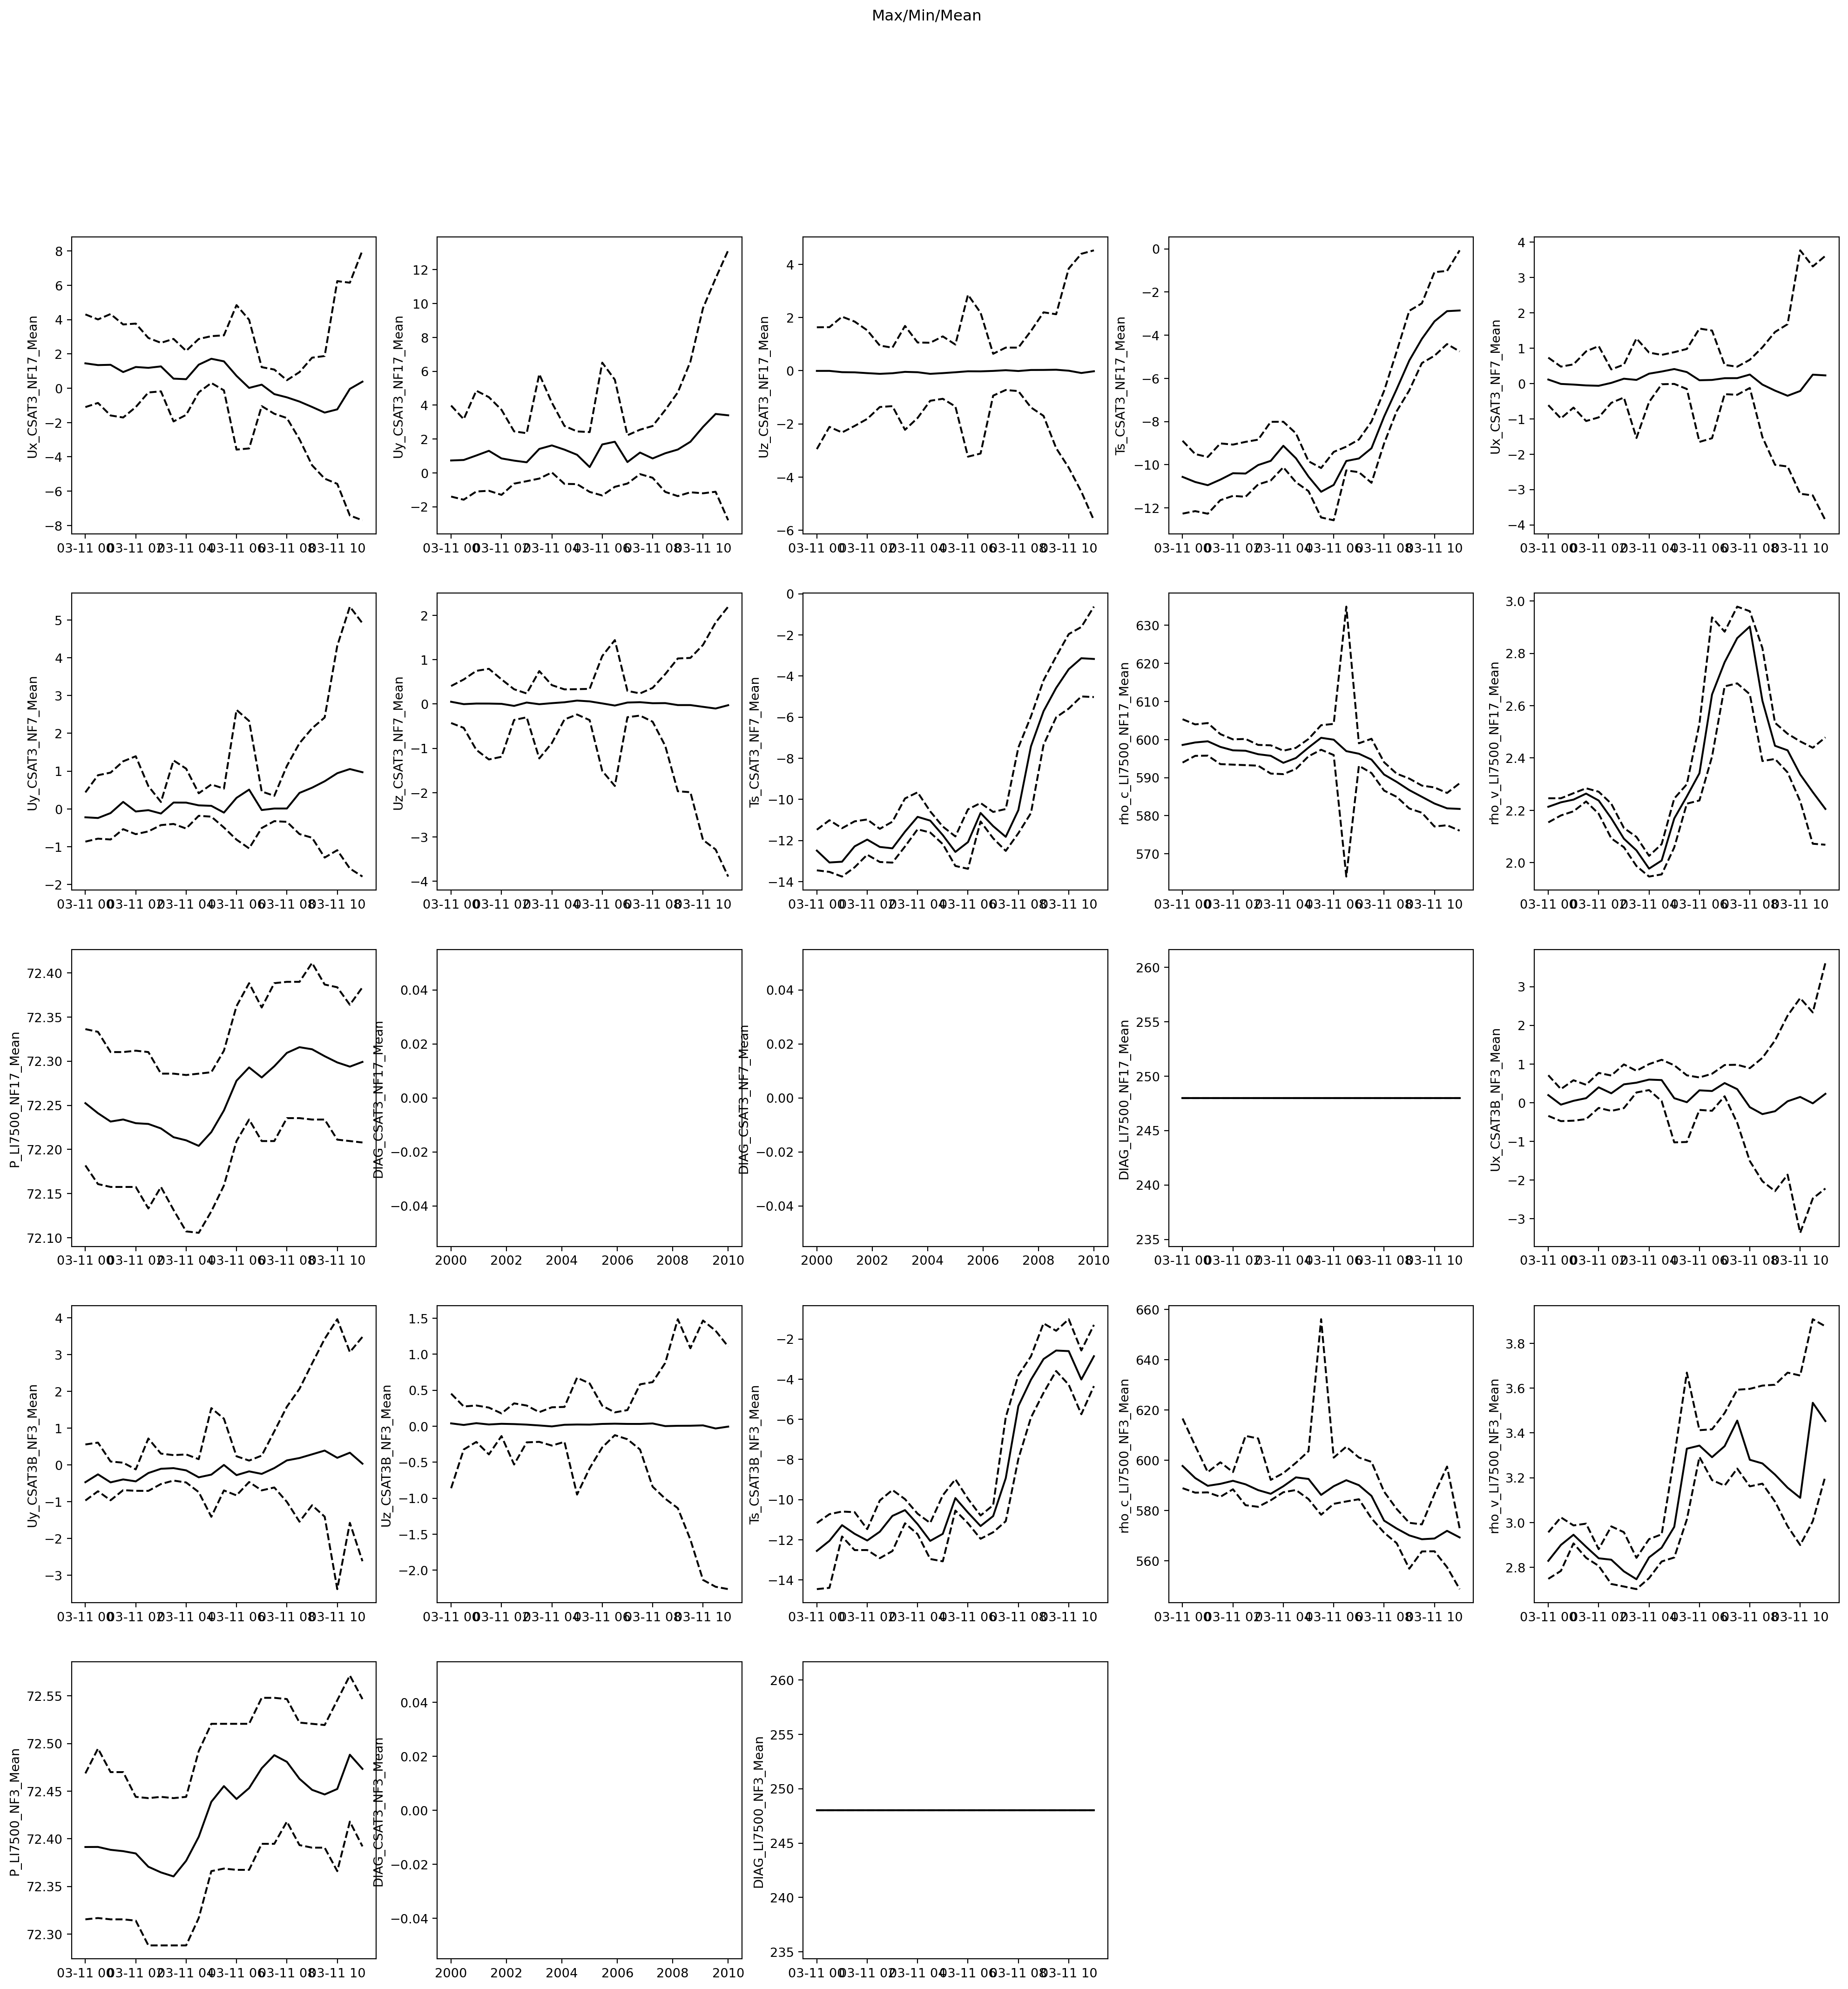

In [142]:
fig = plt.figure(figsize=(5*5, 5*5), dpi=196)
fig.tight_layout(w_pad = 300)
i = 0
for v in processor.summary.columns:
    if '_Max' in v:
        i += 1
        fig.add_subplot(5, 5, i)
        plt.plot(processor.summary[v], linestyle='--', color='k')
    if '_Min' in v:
        plt.plot(processor.summary[v], linestyle='--', color='k')
    if '_Mean' in v:
        plt.plot(processor.summary[v], color='k')
        plt.ylabel(v)
plt.suptitle('Max/Min/Mean');

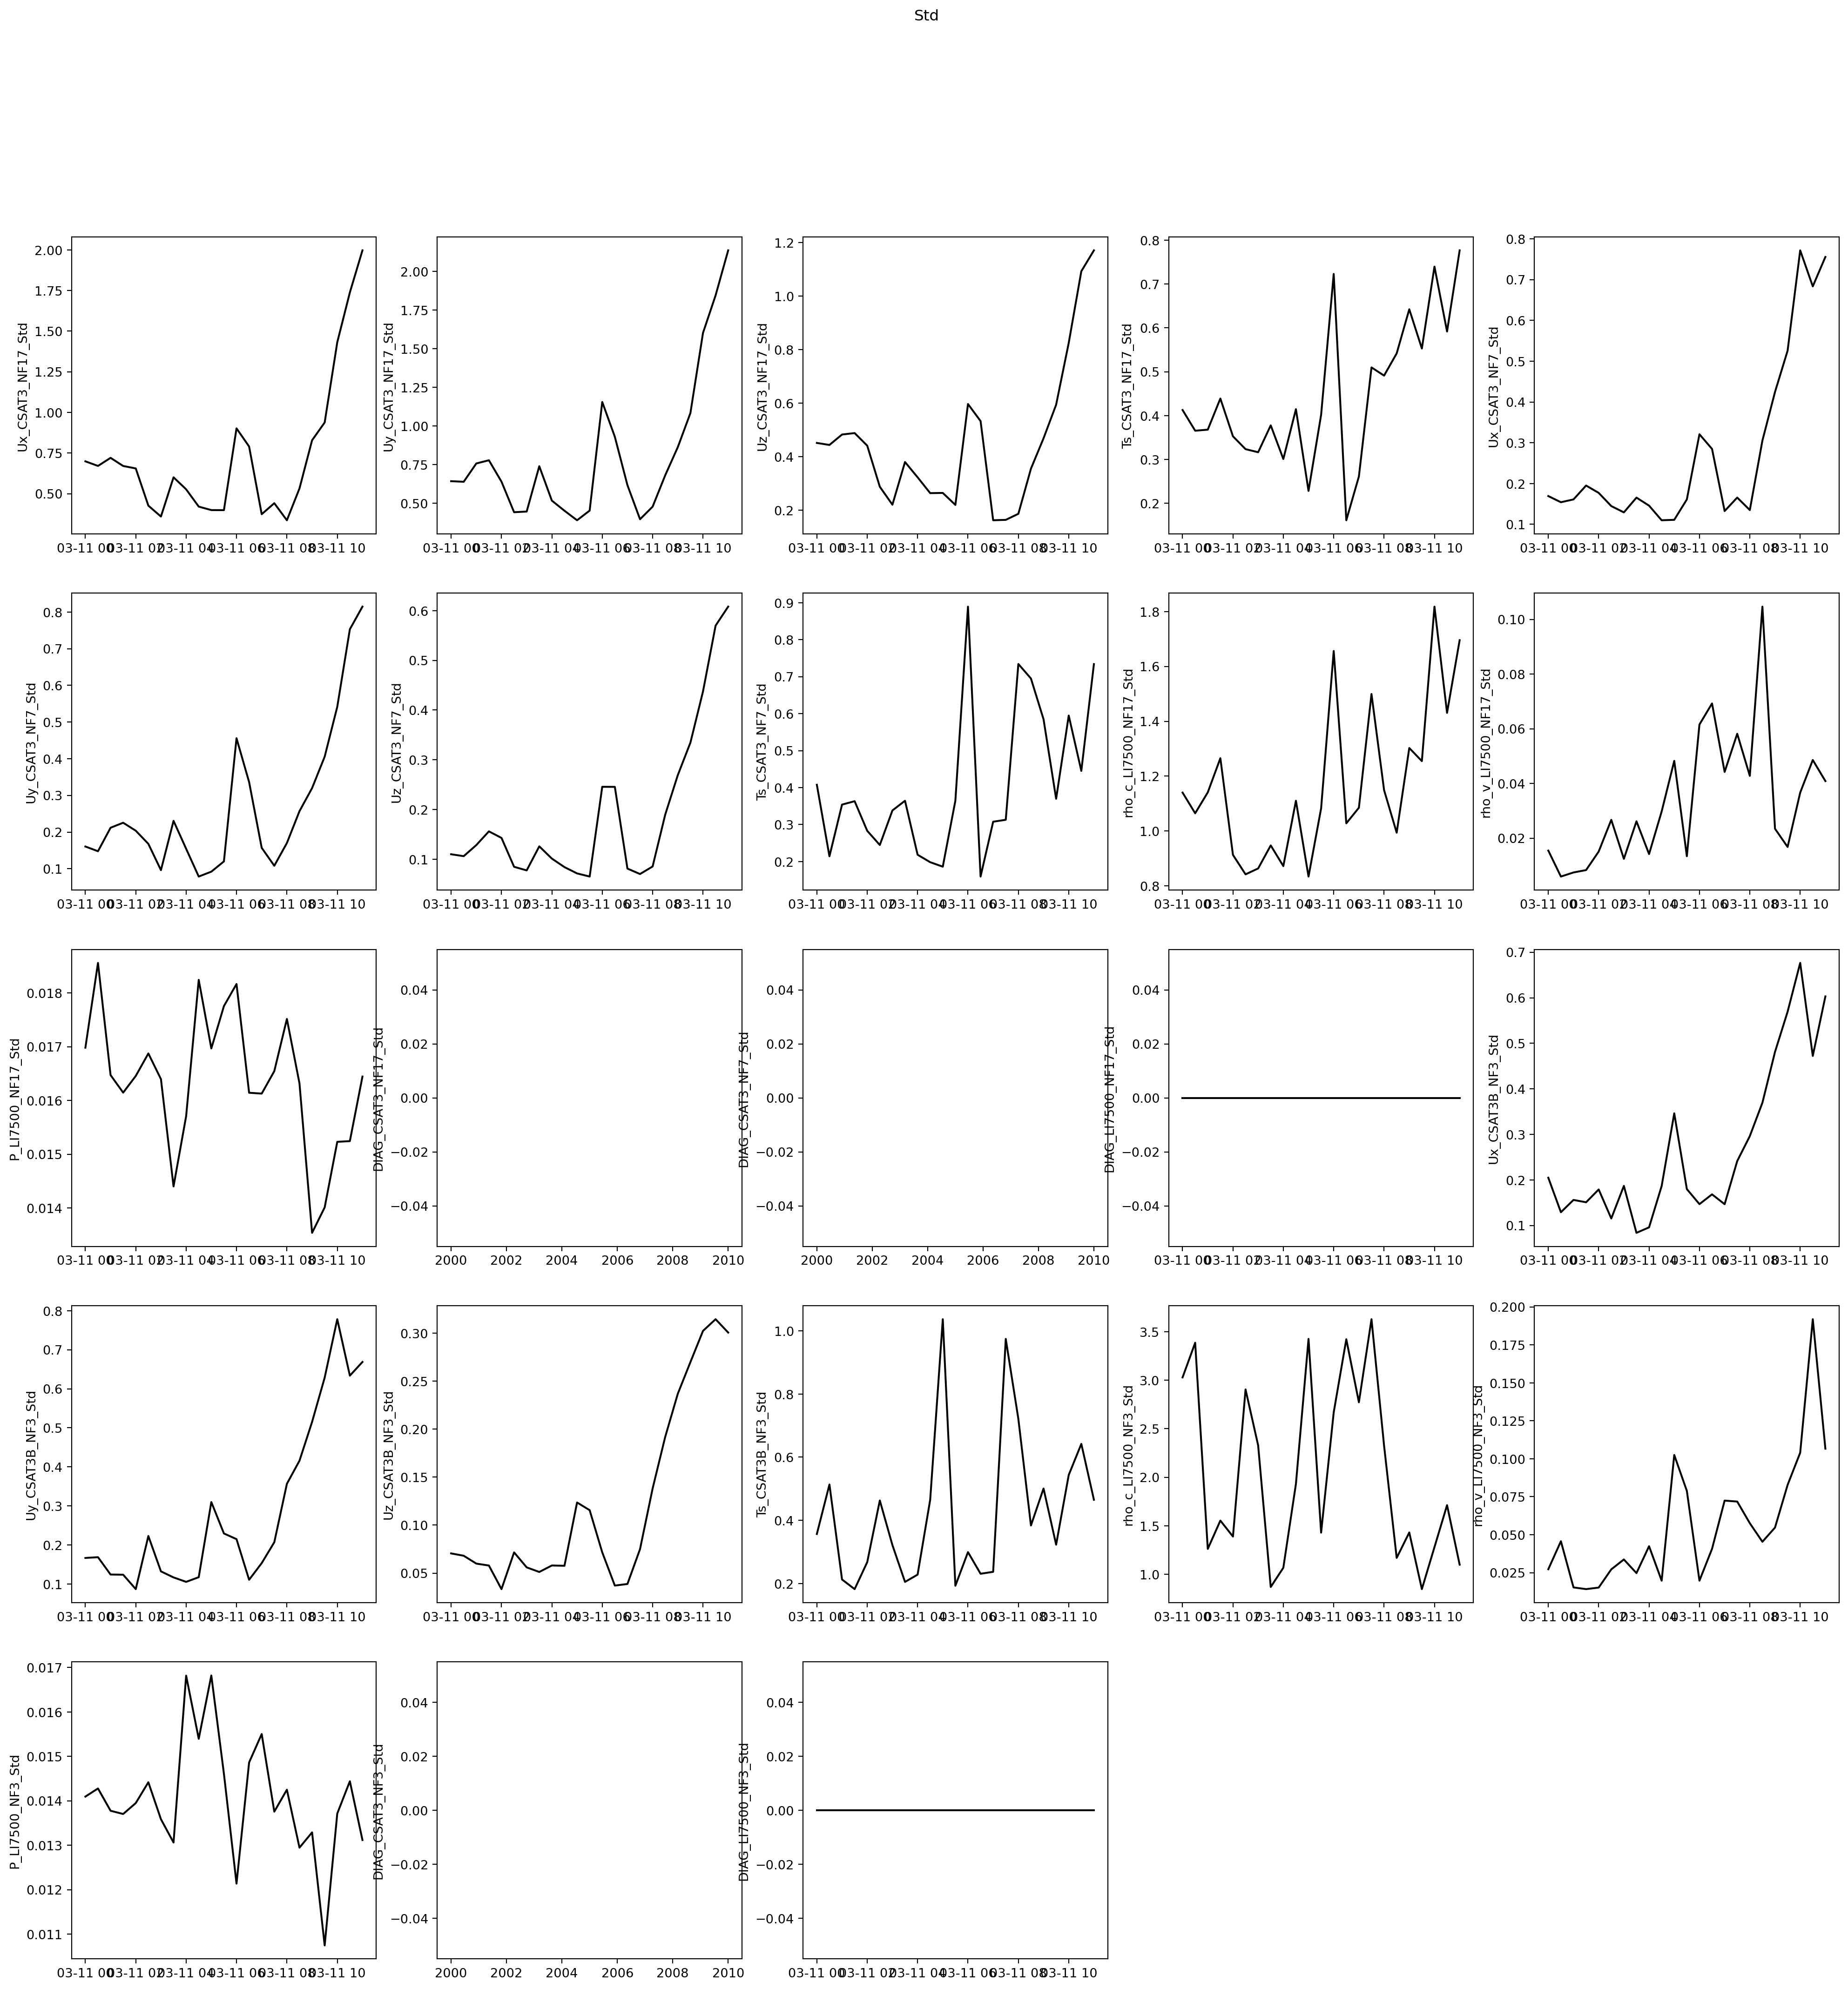

In [143]:
fig = plt.figure(figsize=(5*5, 5*5), dpi=196)
fig.tight_layout(w_pad = 300)
i = 0
for v in processor.summary.columns:
    if '_Std' in v:
        i += 1
        fig.add_subplot(5, 5, i)
        plt.plot(processor.summary[v], color='k')
        plt.ylabel(v)
plt.suptitle('Std');

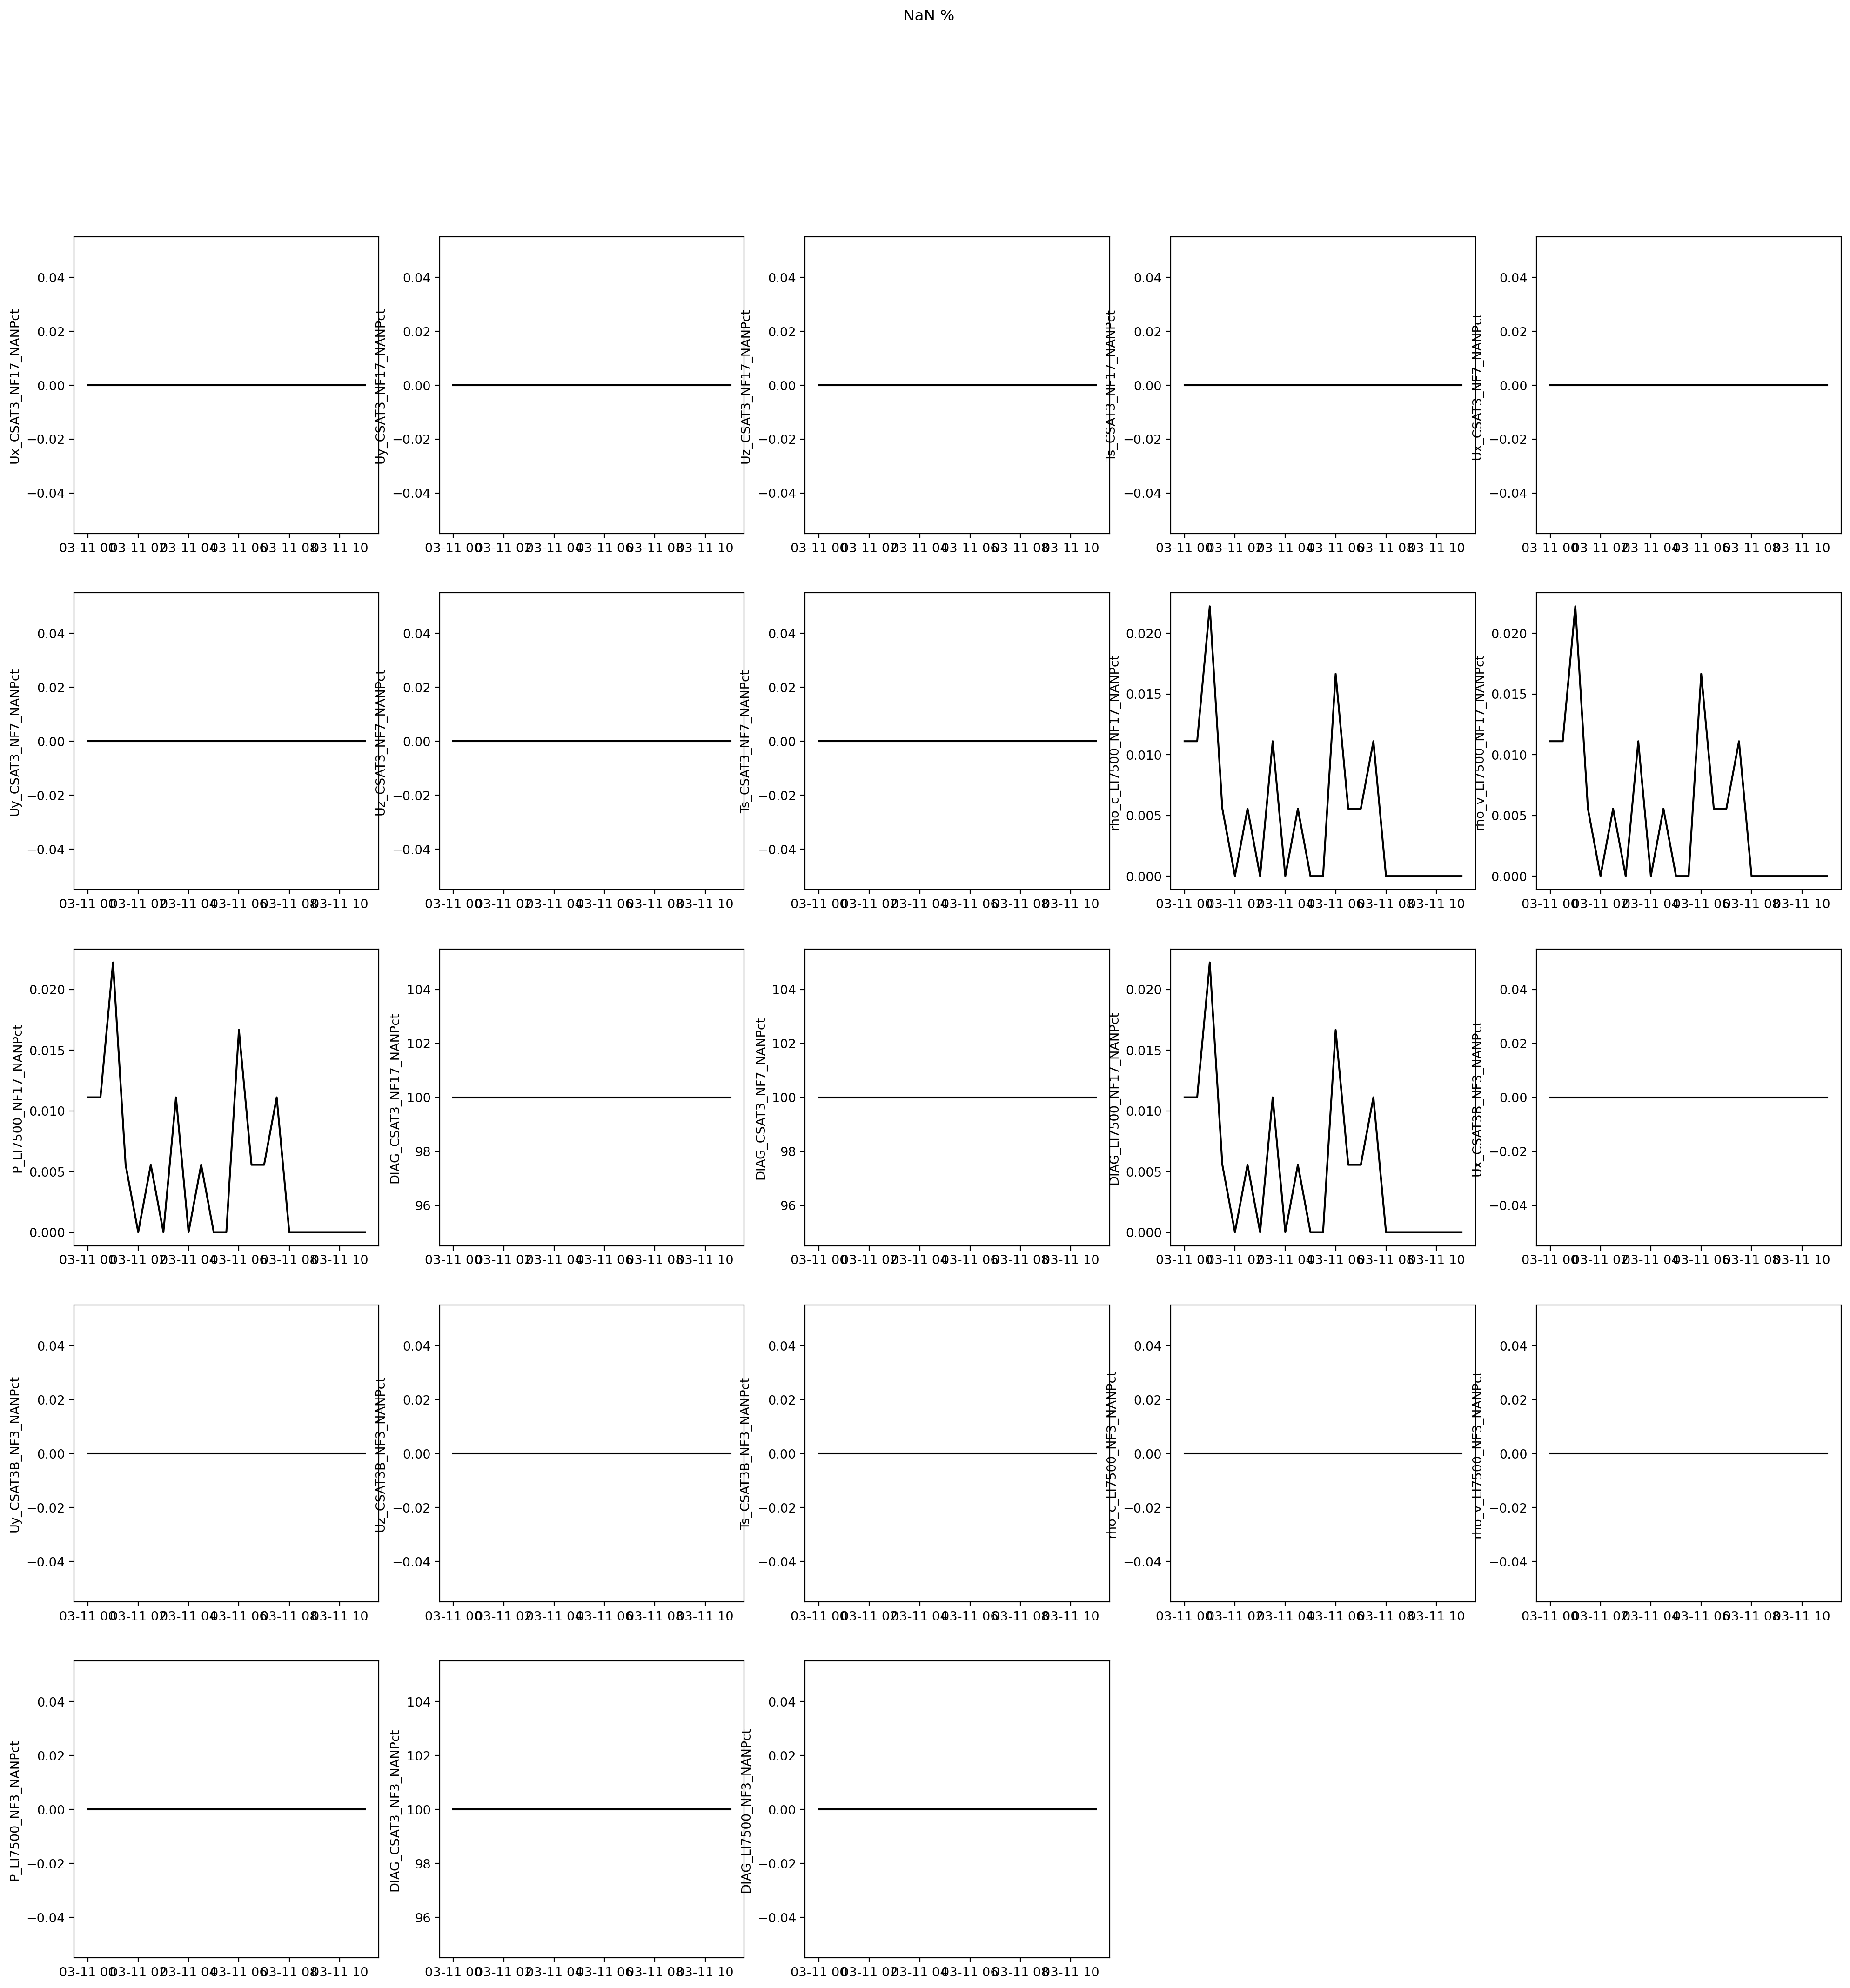

In [144]:
fig = plt.figure(figsize=(5*5, 5*5), dpi=196)
fig.tight_layout(w_pad = 300)
i = 0
for v in processor.summary.columns:
    if '_NANPct' in v:
        i += 1
        fig.add_subplot(5, 5, i)
        plt.plot(processor.summary[v], color='k')
        plt.ylabel(v)
plt.suptitle('NaN %');